In [1]:
import pandas as pd
import numpy as np
from numpy import newaxis
import matplotlib.pyplot as plt
import random
import seaborn as sns
import itertools
import os
from PIL import Image
import math
from matplotlib import gridspec
import matplotlib.collections

from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes
import matplotlib.collections

from tqdm import *
# nice progress bars otherwise

In [33]:
"""
XKCD plot generator
-------------------
Author: Jake Vanderplas

This is a script that will take any matplotlib line diagram, and convert it
to an XKCD-style plot.  It will work for plots with line & text elements,
including axes labels and titles (but not axes tick labels).

The idea for this comes from work by Damon McDougall
  http://www.mail-archive.com/matplotlib-users@lists.sourceforge.net/msg25499.html
"""
import numpy as np
import pylab as pl
from scipy import interpolate, signal
import matplotlib.font_manager as fm


# We need a special font for the code below.  It can be downloaded this way:
import os
from urllib.request import urlopen
if not os.path.exists('Humor-Sans.ttf'):
    fhandle = urllib.urlopen('http://antiyawn.com/uploads/Humor-Sans-1.0.ttf')
    open('Humor-Sans.ttf', 'wb').write(fhandle.read())

    
def xkcd_line(x, y, xlim=None, ylim=None,
              mag=1.0, f1=30, f2=0.05, f3=15):
    """
    Mimic a hand-drawn line from (x, y) data

    Parameters
    ----------
    x, y : array_like
        arrays to be modified
    xlim, ylim : data range
        the assumed plot range for the modification.  If not specified,
        they will be guessed from the  data
    mag : float
        magnitude of distortions
    f1, f2, f3 : int, float, int
        filtering parameters.  f1 gives the size of the window, f2 gives
        the high-frequency cutoff, f3 gives the size of the filter
    
    Returns
    -------
    x, y : ndarrays
        The modified lines
    """
    x = np.asarray(x)
    y = np.asarray(y)
    
    # get limits for rescaling
    if xlim is None:
        xlim = (x.min(), x.max())
    if ylim is None:
        ylim = (y.min(), y.max())

    if xlim[1] == xlim[0]:
        xlim = ylim
        
    if ylim[1] == ylim[0]:
        ylim = xlim

    # scale the data
    x_scaled = (x - xlim[0]) * 1. / (xlim[1] - xlim[0])
    y_scaled = (y - ylim[0]) * 1. / (ylim[1] - ylim[0])

    # compute the total distance along the path
    dx = x_scaled[1:] - x_scaled[:-1]
    dy = y_scaled[1:] - y_scaled[:-1]
    dist_tot = np.sum(np.sqrt(dx * dx + dy * dy))

    # number of interpolated points is proportional to the distance
    Nu = int(200 * dist_tot)
    u = np.arange(-1, Nu + 1) * 1. / (Nu - 1)

    # interpolate curve at sampled points
    k = min(3, len(x) - 1)
    res = interpolate.splprep([x_scaled, y_scaled], s=0, k=k)
    x_int, y_int = interpolate.splev(u, res[0]) 

    # we'll perturb perpendicular to the drawn line
    dx = x_int[2:] - x_int[:-2]
    dy = y_int[2:] - y_int[:-2]
    dist = np.sqrt(dx * dx + dy * dy)

    # create a filtered perturbation
    coeffs = mag * np.random.normal(0, 0.01, len(x_int) - 2)
    b = signal.firwin(f1, f2 * dist_tot, window=('kaiser', f3))
    response = signal.lfilter(b, 1, coeffs)

    x_int[1:-1] += response * dy / dist
    y_int[1:-1] += response * dx / dist

    # un-scale data
    x_int = x_int[1:-1] * (xlim[1] - xlim[0]) + xlim[0]
    y_int = y_int[1:-1] * (ylim[1] - ylim[0]) + ylim[0]
    
    return x_int, y_int


def XKCDify(ax, mag=1.0,
            f1=50, f2=0.01, f3=15,
            bgcolor='w',
            xaxis_loc=None,
            yaxis_loc=None,
            xaxis_arrow='+',
            yaxis_arrow='+',
            ax_extend=0.1,
            expand_axes=False):
    """Make axis look hand-drawn

    This adjusts all lines, text, legends, and axes in the figure to look
    like xkcd plots.  Other plot elements are not modified.
    
    Parameters
    ----------
    ax : Axes instance
        the axes to be modified.
    mag : float
        the magnitude of the distortion
    f1, f2, f3 : int, float, int
        filtering parameters.  f1 gives the size of the window, f2 gives
        the high-frequency cutoff, f3 gives the size of the filter
    xaxis_loc, yaxis_log : float
        The locations to draw the x and y axes.  If not specified, they
        will be drawn from the bottom left of the plot
    xaxis_arrow, yaxis_arrow : str
        where to draw arrows on the x/y axes.  Options are '+', '-', '+-', or ''
    ax_extend : float
        How far (fractionally) to extend the drawn axes beyond the original
        axes limits
    expand_axes : bool
        if True, then expand axes to fill the figure (useful if there is only
        a single axes in the figure)
    """
    # Get axes aspect
    ext = ax.get_window_extent().extents
    aspect = (ext[3] - ext[1]) / (ext[2] - ext[0])

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    xspan = xlim[1] - xlim[0]
    yspan = ylim[1] - xlim[0]

    xax_lim = (xlim[0] - ax_extend * xspan,
               xlim[1] + ax_extend * xspan)
    yax_lim = (ylim[0] - ax_extend * yspan,
               ylim[1] + ax_extend * yspan)

    if xaxis_loc is None:
        xaxis_loc = ylim[0]

    if yaxis_loc is None:
        yaxis_loc = xlim[0]

    # Draw axes
    xaxis = pl.Line2D([xax_lim[0], xax_lim[1]], [xaxis_loc, xaxis_loc],
                      linestyle='-', color='k')
    yaxis = pl.Line2D([yaxis_loc, yaxis_loc], [yax_lim[0], yax_lim[1]],
                      linestyle='-', color='k')

    # Label axes3, 0.5, 'hello', fontsize=14)
    ax.text(xax_lim[1], xaxis_loc - 0.02 * yspan, ax.get_xlabel(),
            fontsize=14, ha='right', va='top', rotation=12)
    ax.text(yaxis_loc - 0.02 * xspan, yax_lim[1], ax.get_ylabel(),
            fontsize=14, ha='right', va='top', rotation=78)
    ax.set_xlabel('')
    ax.set_ylabel('')

    # Add title
    ax.text(0.5 * (xax_lim[1] + xax_lim[0]), yax_lim[1],
            ax.get_title(),
            ha='center', va='bottom', fontsize=16)
    ax.set_title('')

    Nlines = len(ax.lines)
    lines = [xaxis, yaxis] + [ax.lines.pop(0) for i in range(Nlines)]

    for line in lines:
        x, y = line.get_data()

        x_int, y_int = xkcd_line(x, y, xlim, ylim,
                                 mag, f1, f2, f3)

        # create foreground and background line
        lw = line.get_linewidth()
        line.set_linewidth(2 * lw)
        line.set_data(x_int, y_int)

        # don't add background line for axes
        if (line is not xaxis) and (line is not yaxis):
            line_bg = pl.Line2D(x_int, y_int, color=bgcolor,
                                linewidth=8 * lw)

            ax.add_line(line_bg)
        ax.add_line(line)

    # Draw arrow-heads at the end of axes lines
    arr1 = 0.03 * np.array([-1, 0, -1])
    arr2 = 0.02 * np.array([-1, 0, 1])

    arr1[::2] += np.random.normal(0, 0.005, 2)
    arr2[::2] += np.random.normal(0, 0.005, 2)

    x, y = xaxis.get_data()
    if '+' in str(xaxis_arrow):
        ax.plot(x[-1] + arr1 * xspan * aspect,
                y[-1] + arr2 * yspan,
                color='k', lw=2)
    if '-' in str(xaxis_arrow):
        ax.plot(x[0] - arr1 * xspan * aspect,
                y[0] - arr2 * yspan,
                color='k', lw=2)

    x, y = yaxis.get_data()
    if '+' in str(yaxis_arrow):
        ax.plot(x[-1] + arr2 * xspan * aspect,
                y[-1] + arr1 * yspan,
                color='k', lw=2)
    if '-' in str(yaxis_arrow):
        ax.plot(x[0] - arr2 * xspan * aspect,
                y[0] - arr1 * yspan,
                color='k', lw=2)

    # Change all the fonts to humor-sans.
    prop = fm.FontProperties(fname='Humor-Sans.ttf', size=16)
    for text in ax.texts:
        text.set_fontproperties(prop)
    
    # modify legend
    leg = ax.get_legend()
    if leg is not None:
        leg.set_frame_on(False)
        
        for child in leg.get_children():
            if isinstance(child, pl.Line2D):
                x, y = child.get_data()
                child.set_data(xkcd_line(x, y, mag=10, f1=100, f2=0.001))
                child.set_linewidth(2 * child.get_linewidth())
            if isinstance(child, pl.Text):
                child.set_fontproperties(prop)
    
    # Set the axis limits
    ax.set_xlim(xax_lim[0] - 0.1 * xspan,
                xax_lim[1] + 0.1 * xspan)
    ax.set_ylim(yax_lim[0] - 0.1 * yspan,
                yax_lim[1] + 0.1 * yspan)

    # adjust the axes
    ax.set_xticks([])
    ax.set_yticks([])      

    if expand_axes:
        ax.figure.set_facecolor(bgcolor)
        ax.set_axis_off()
        ax.set_position([0, 0, 1, 1])
    
    return ax

AttributeError: module 'urllib' has no attribute 'urlopen'

In [26]:
dataFolder = 'data/mainData/'
plt.ion()

In [23]:
def read_image(id):
    if id[-4:] == '.npy':
        X = np.load(dataFolder+id)
    elif os.path.isfile(dataFolder+id+'.npy'):
        X = np.load(dataFolder+id + '.npy')
    elif os.path.isfile(dataFolder+id+'-g.csv'):
        X = np.genfromtxt(dataFolder+id+'-g.csv', delimiter=",")
    else:
        X = None

    X = np.float32(X)
    return X


1237660344469487651


NameError: name 'XKCDify' is not defined

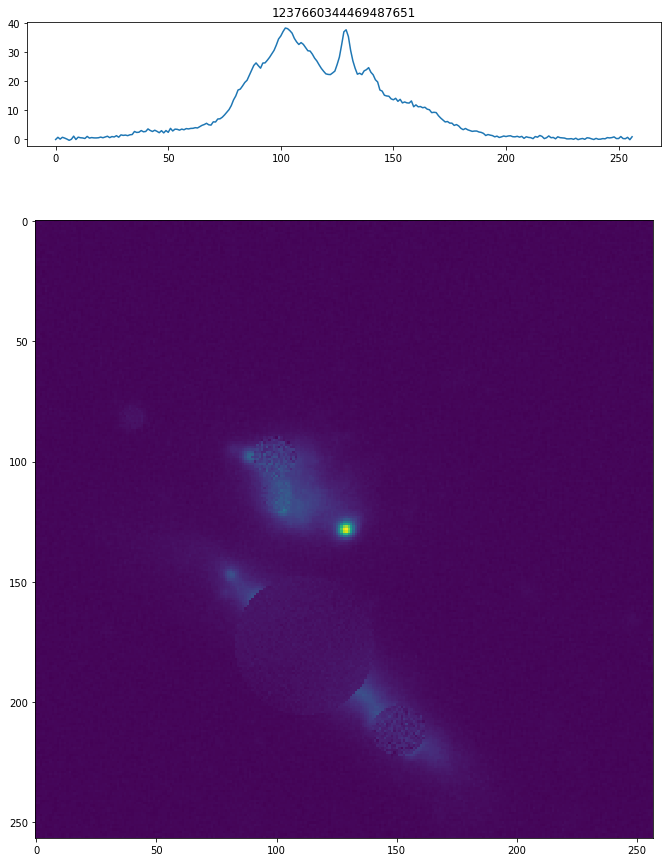

In [30]:
def drawOneGalaxy(galaxyID):
    oneImageData = read_image(galaxyID)
    print(galaxyID)

    # new image
    fig = plt.figure(figsize=(15,15))
    #set grid spec for the 4 graphs
    gs = gridspec.GridSpec(2, 2, width_ratios=[5, 1], height_ratios=[1,5]) 

    #draw image
    plt.title("raw")
    plt.subplot(gs[2])
    plt.imshow(oneImageData)
    
    # horizontal (top) sum
    plt.subplot(gs[0])
    plt.title(galaxyID)
    ax = plt.plot(oneImageData.sum(axis=0))
    XKCDify(ax)
    

    # vertical (bottom-right) sum
    ax = plt.subplot(gs[3])
    ss = np.flip(oneImageData.sum(axis=1),axis=0)
    plt.scatter(x=ss, y=list(range(oneImageData.shape[1])), s=1)
    lines = [[(ss[i-1],i-1),(ss[i],i)] for i in range(1,len(ss))]
    lc = matplotlib.collections.LineCollection(lines)
    ax.add_collection(lc)
    
    #value histogram
    plt.subplot(gs[1])
    plt.hist(oneImageData.reshape(-1), bins=100)
    plt.yscale('log')    
    sns.despine()
    plt.tight_layout()

    #add small log of image
    ax = fig.add_axes([0.02,0.6,.2,.2])
    plt.imshow(np.log(oneImageData-oneImageData.min()+0.00001))

drawOneGalaxy('1237660344469487651')

In [3]:
df = pd.read_csv('sp-newSource-ReadLog1pNormCrop.75-model5-CVResultDF.csv')

df = df.drop('Unnamed: 0', axis=1)

In [4]:
df.describe()

,SDSS_ID,RA,DEC,D25,redshi,GalSize_kpc,D_Mpc,d_pix_kpc,logMstar,err_logMstar,Distance,lin_mass,lin_err,pred,lin_pred,cvpred,lincvpred,deltapred,lindeltapred
count,7.885100e+04,78851.000000,78851.000000,78851.000000,78851.000000,78851.000000,78851.000000,78851.000000,78851.000000,78851.000000,78851.000000,7.885100e+04,7.885100e+04,78851.000000,7.885100e+04,78851.000000,7.885100e+04,78851.000000,7.885100e+04
mean,1.237662e+18,185.303775,25.672447,0.557644,0.058701,38.101843,251.574576,0.487867,10.558197,0.031070,251.574576,7.898269e+10,4.398954e+09,10.558030,7.570886e+10,10.558280,7.472245e+10,0.124758,4.260241e+09
std,5.871112e+12,57.111612,18.944782,0.194465,0.032567,19.838329,139.570856,0.270663,0.654456,0.016953,139.570856,9.624108e+10,5.552716e+09,0.635357,8.622400e+10,0.626735,8.340013e+10,0.128504,3.662665e+10
min,1.237646e+18,0.009450,-11.238420,0.407380,0.010000,5.248929,42.857142,0.083111,7.376000,0.001000,42.857142,2.376840e+07,4.756699e+05,7.572723,3.738723e+07,7.875410,7.506029e+07,0.000002,-1.093658e+12
25%,1.237658e+18,154.486425,9.795145,0.436516,0.033800,24.390653,144.857136,0.280915,10.200000,0.019000,144.857136,1.584893e+10,1.023221e+09,10.201942,1.591995e+10,10.204806,1.602531e+10,0.039749,-5.928316e+09
50%,1.237662e+18,186.753000,24.400580,0.489779,0.052300,35.043089,224.142852,0.434670,10.692000,0.028000,224.142852,4.920395e+10,2.693666e+09,10.684481,4.835938e+10,10.678615,4.771060e+10,0.087977,3.018899e+08
75%,1.237665e+18,221.979375,40.093400,0.602560,0.075600,47.500516,323.999992,0.628319,11.030000,0.039000,323.999992,1.071519e+11,5.603185e+09,11.024883,1.058968e+11,11.021144,1.049890e+11,0.164663,9.676779e+09
max,1.237680e+18,359.994900,70.133250,10.964781,0.294800,1373.931687,1263.428628,2.450110,12.326000,0.778000,1263.428628,2.118361e+12,1.414535e+11,12.136512,1.369343e+12,12.156807,1.434850e+12,2.226457,1.432062e+12


In [5]:
df.head()

,SDSS_ID,RA,DEC,D25,redshi,GalSize_kpc,D_Mpc,d_pix_kpc,logMstar,err_logMstar,Distance,lin_mass,lin_err,hasFile,pred,lin_pred,cvpred,lincvpred,deltapred,lindeltapred
0,1237650369947435223,185.44185,-3.08192,0.416869,0.0897,46.616726,384.428565,0.745505,11.302,0.022,384.428565,2.004472e+11,1.015403e+10,True,11.327156,2.124009e+11,11.322961,2.103588e+11,0.020961,-9.911596e+09
1,1237662263778410573,211.48530,9.02645,1.023293,0.0233,29.723862,99.857141,0.193648,10.524,0.017,99.857141,3.341950e+10,1.308171e+09,True,10.501191,3.170960e+10,10.499479,3.158487e+10,0.024521,1.834638e+09
2,1237654881815757047,226.44975,4.93666,0.524807,0.0801,52.406104,343.285714,0.665718,11.072,0.012,343.285714,1.180321e+11,3.261346e+09,True,11.146405,1.400892e+11,11.149492,1.410886e+11,0.077492,-2.305652e+10
3,1237661463301914866,234.70845,33.98374,0.407380,0.0734,37.277381,314.571421,0.610034,10.637,0.013,314.571421,4.335109e+10,1.297654e+09,True,10.521984,3.326471e+10,10.467819,2.936425e+10,0.169181,1.398683e+10
4,1237655463240269922,220.99650,55.96656,0.501187,0.0759,47.423228,325.285728,0.630812,11.275,0.024,325.285728,1.883649e+11,1.040943e+10,True,11.242136,1.746368e+11,11.259348,1.816969e+11,0.015652,6.667973e+09


In [6]:
df = df.sort_values(by='deltapred', ascending=False).reset_index()

In [7]:
df.head()

,index,SDSS_ID,RA,DEC,D25,redshi,GalSize_kpc,D_Mpc,d_pix_kpc,logMstar,...,Distance,lin_mass,lin_err,hasFile,pred,lin_pred,cvpred,lincvpred,deltapred,lindeltapred
0,30653,1237660344469487651,135.06345,35.72214,0.851138,0.0102,10.823047,43.714287,0.084773,7.412,...,43.714287,2.582260e+07,4.756699e+05,True,7.572723,3.738723e+07,9.638457,4.349672e+09,2.226457,-4.323849e+09
1,147,1237661069236175081,122.46120,6.71449,0.645654,0.0509,40.970110,218.142862,0.423035,8.336,...,218.142862,2.167704e+08,3.294273e+07,True,8.954748,9.010475e+08,10.322836,2.102982e+10,1.986836,-2.081305e+10
2,75676,1237661872942284878,191.02245,45.00159,0.933254,0.0124,14.426835,53.142859,0.103058,7.376,...,53.142859,2.376840e+07,6.239080e+06,True,9.123011,1.327429e+09,9.233909,1.713597e+09,1.857909,-1.689828e+09
3,50947,1237671769072533603,227.57250,58.17851,0.645654,0.0307,24.710851,131.571429,0.255151,8.804,...,131.571429,6.367955e+08,9.824048e+07,True,9.159124,1.442528e+09,10.529992,3.388383e+10,1.725992,-3.324703e+10
4,60573,1237670449986666600,139.67625,16.47949,0.645654,0.0338,27.206083,144.857136,0.280915,8.660,...,144.857136,4.570882e+08,9.367112e+07,True,8.889101,7.746426e+08,10.303047,2.009312e+10,1.643047,-1.963604e+10


In [13]:
plt.ion()


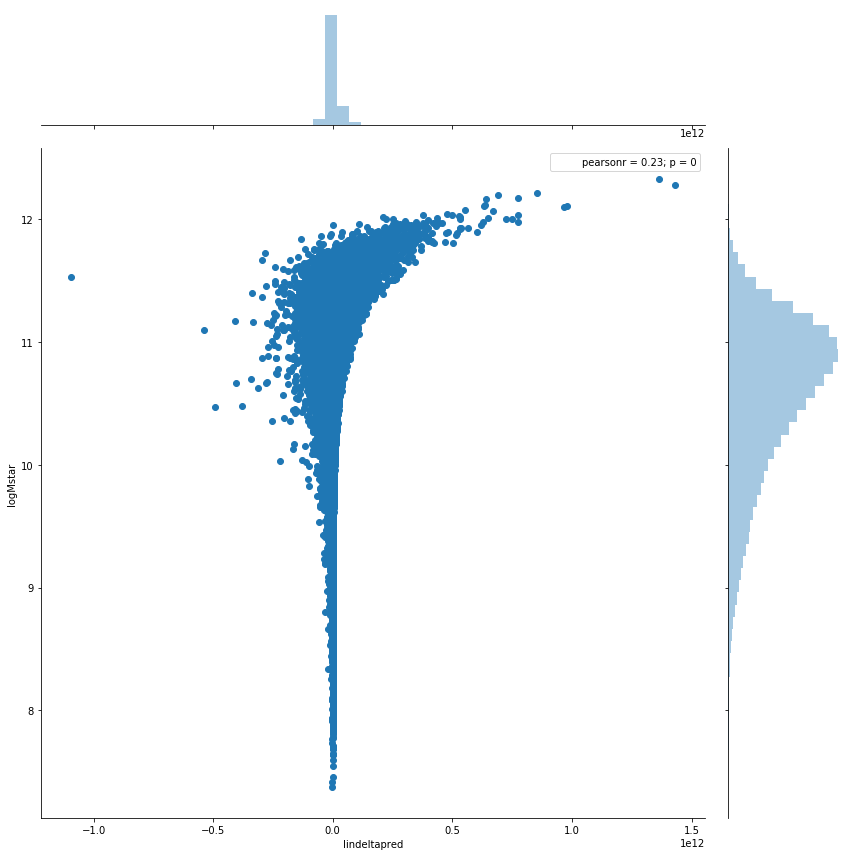

In [15]:
sns.jointplot(data=df, x='lindeltapred', y='logMstar', size=12)

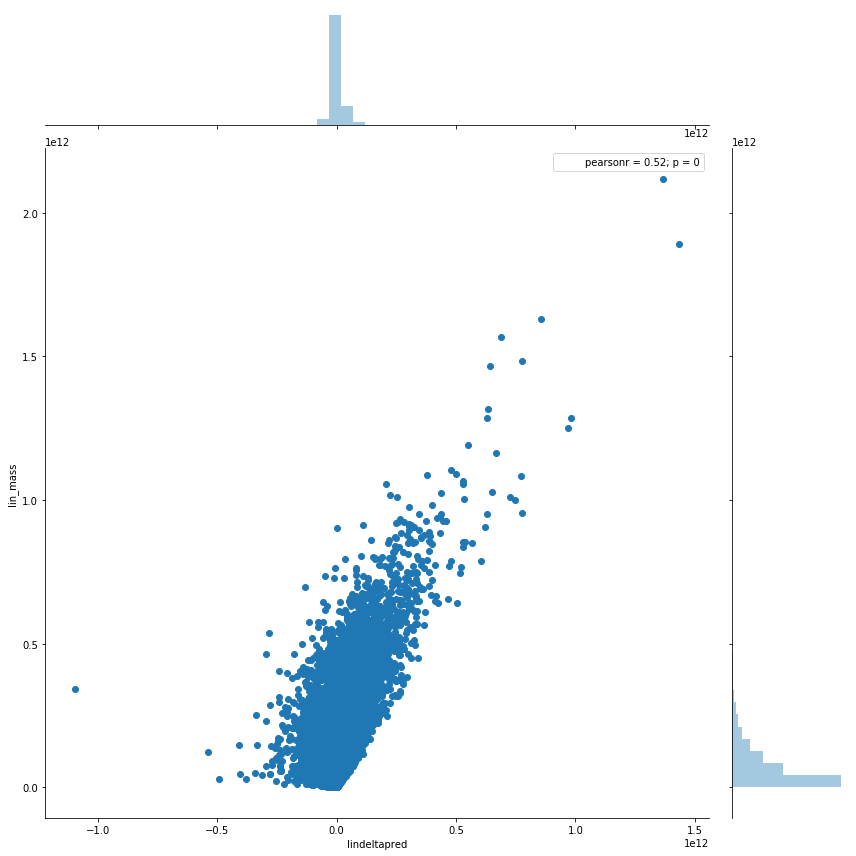

In [16]:
sns.jointplot(data=df, x='lindeltapred', y='lin_mass', size=12)

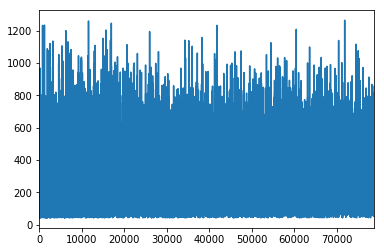

In [17]:
df.Distance.plot()

(33937, 21) (34834, 21)


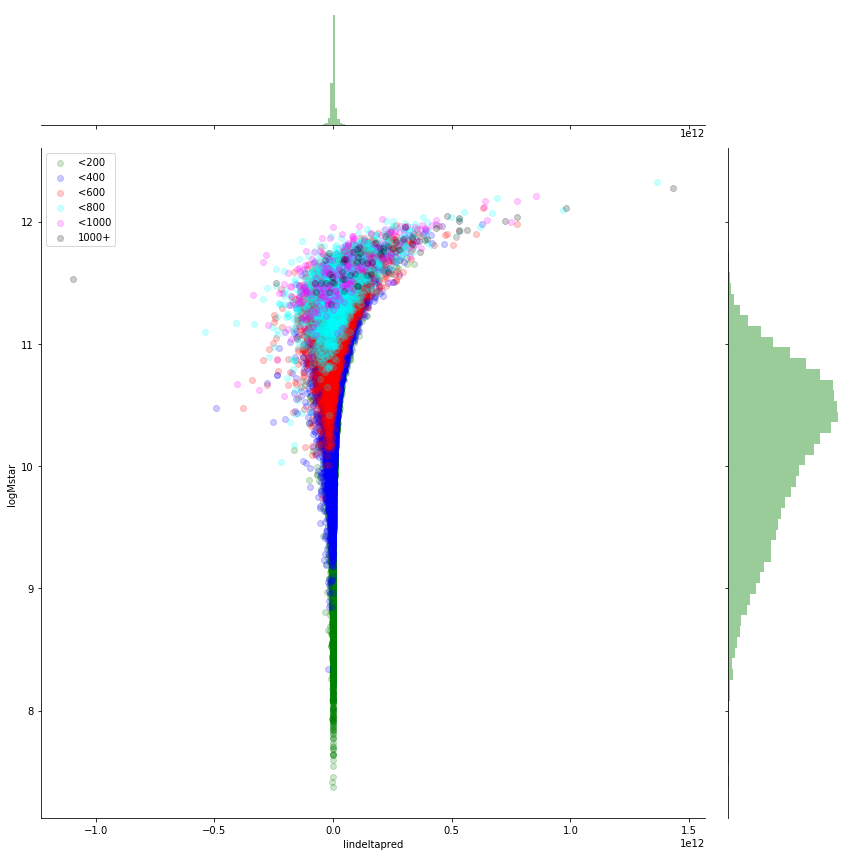

In [18]:

dd1 = df[df.Distance <= 200]
dd2 = df[((df.Distance > 200) & (df.Distance <= 400))]
dd3 = df[((df.Distance > 400) & (df.Distance <= 600))]
dd4 = df[((df.Distance > 600) & (df.Distance <= 800))]
dd5 = df[((df.Distance > 800) & (df.Distance <= 1000))]
dd6 = df[((df.Distance > 1000))]
print(dd1.shape, dd2.shape)
g = sns.jointplot(data=dd1, x='lindeltapred', y='logMstar', size=12, color='g', alpha=.2)

g.x = dd2.lindeltapred
g.y = dd2.logMstar
g.plot_joint(plt.scatter,c='b', alpha=.2)

g.x = dd3.lindeltapred
g.y = dd3.logMstar
g.plot_joint(plt.scatter,c='r', alpha=.2)

g.x = dd4.lindeltapred
g.y = dd4.logMstar
g.plot_joint(plt.scatter,c='cyan', alpha=.2)

g.x = dd5.lindeltapred
g.y = dd5.logMstar
g.plot_joint(plt.scatter,c='magenta', alpha=.2)

g.x = dd6.lindeltapred
g.y = dd6.logMstar
g.plot_joint(plt.scatter,c='black', alpha=.2)

plt.legend(['<200','<400','<600','<800','<1000','1000+'])

(33937, 21) (34834, 21)


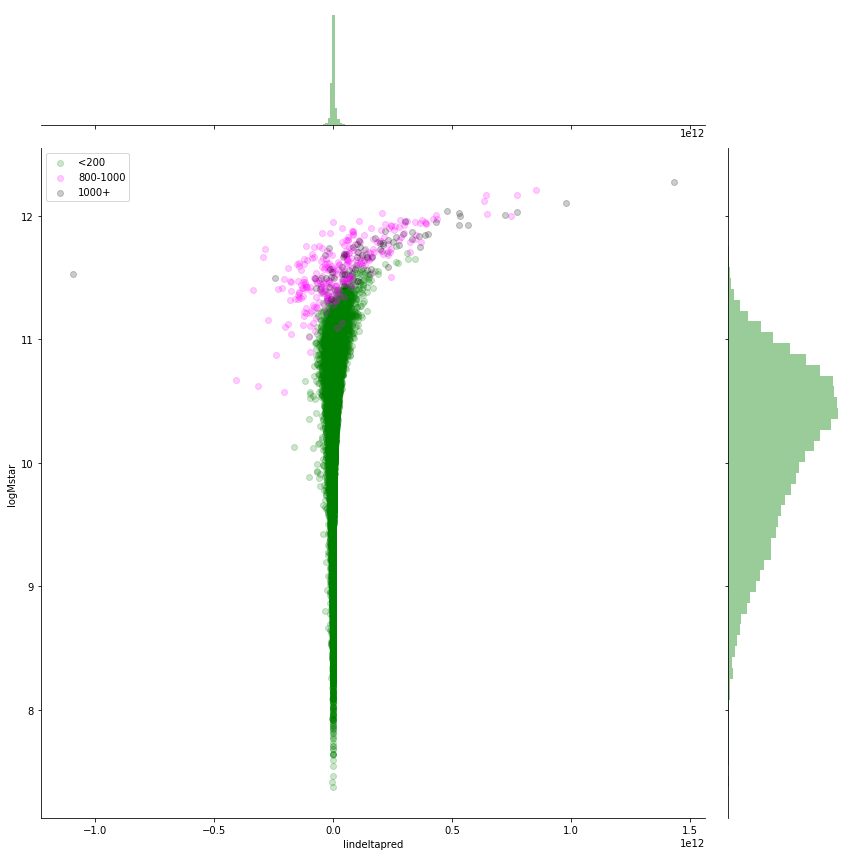

In [19]:

dd1 = df[df.Distance <= 200]
dd2 = df[((df.Distance > 200) & (df.Distance <= 400))]
dd3 = df[((df.Distance > 400) & (df.Distance <= 600))]
dd4 = df[((df.Distance > 600) & (df.Distance <= 800))]
dd5 = df[((df.Distance > 800) & (df.Distance <= 1000))]
dd6 = df[((df.Distance > 1000))]
print(dd1.shape, dd2.shape)
g = sns.jointplot(data=dd1, x='lindeltapred', y='logMstar', size=12, color='g', alpha=.2)

# g.x = dd2.lindeltapred
# g.y = dd2.logMstar
# g.plot_joint(plt.scatter,c='b', alpha=.2)

# g.x = dd3.lindeltapred
# g.y = dd3.logMstar
# g.plot_joint(plt.scatter,c='r', alpha=.2)

# g.x = dd4.lindeltapred
# g.y = dd4.logMstar
# g.plot_joint(plt.scatter,c='cyan', alpha=.2)

g.x = dd5.lindeltapred
g.y = dd5.logMstar
g.plot_joint(plt.scatter,c='magenta', alpha=.2)

g.x = dd6.lindeltapred
g.y = dd6.logMstar
g.plot_joint(plt.scatter,c='black', alpha=.2)

plt.legend(['<200','800-1000','1000+'])

1237660344469487651
1237661069236175081
1237661872942284878
1237671769072533603
1237670449986666600
1237661850392133667
1237656496721494169
1237668271362474177
1237657071694053618
1237652933495881852


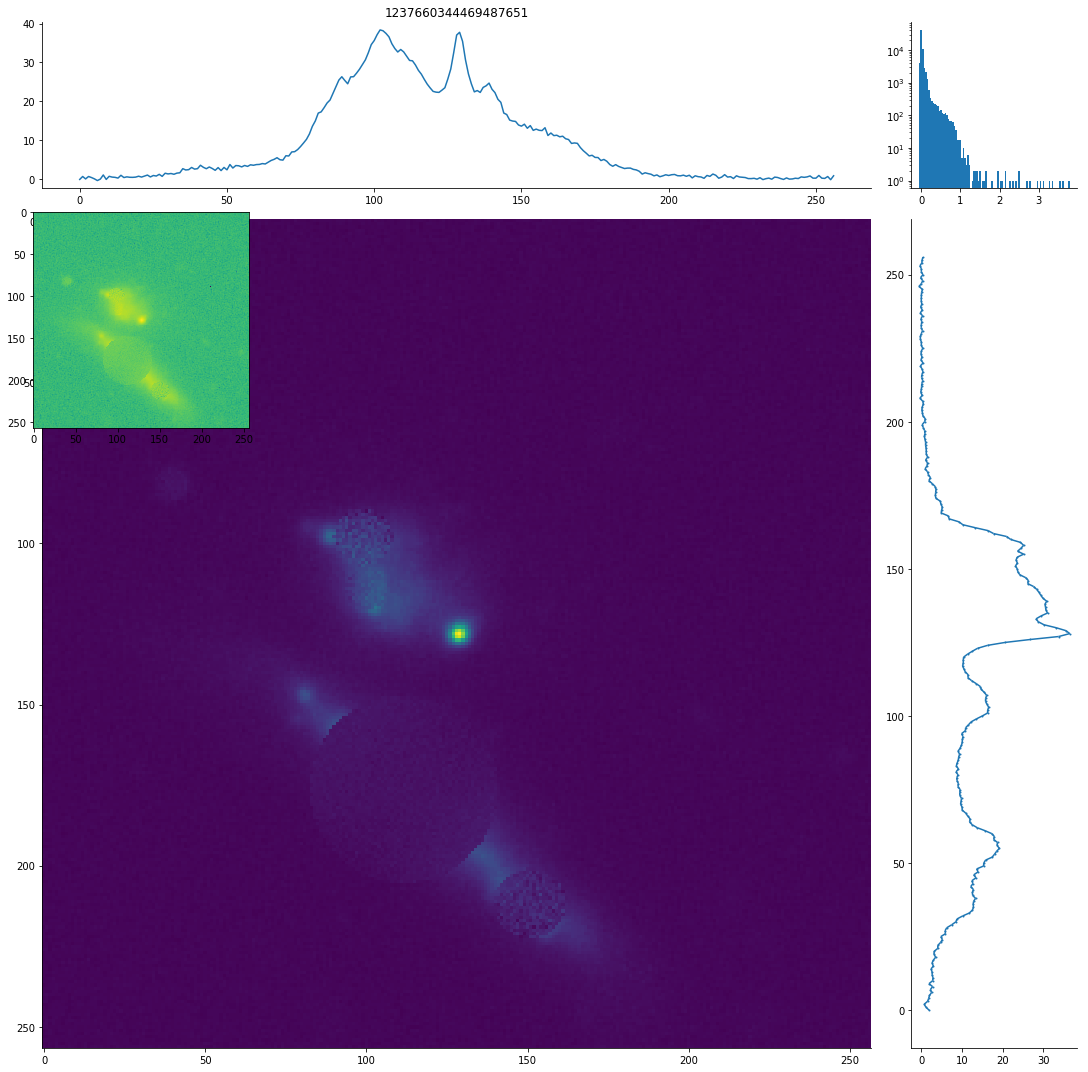

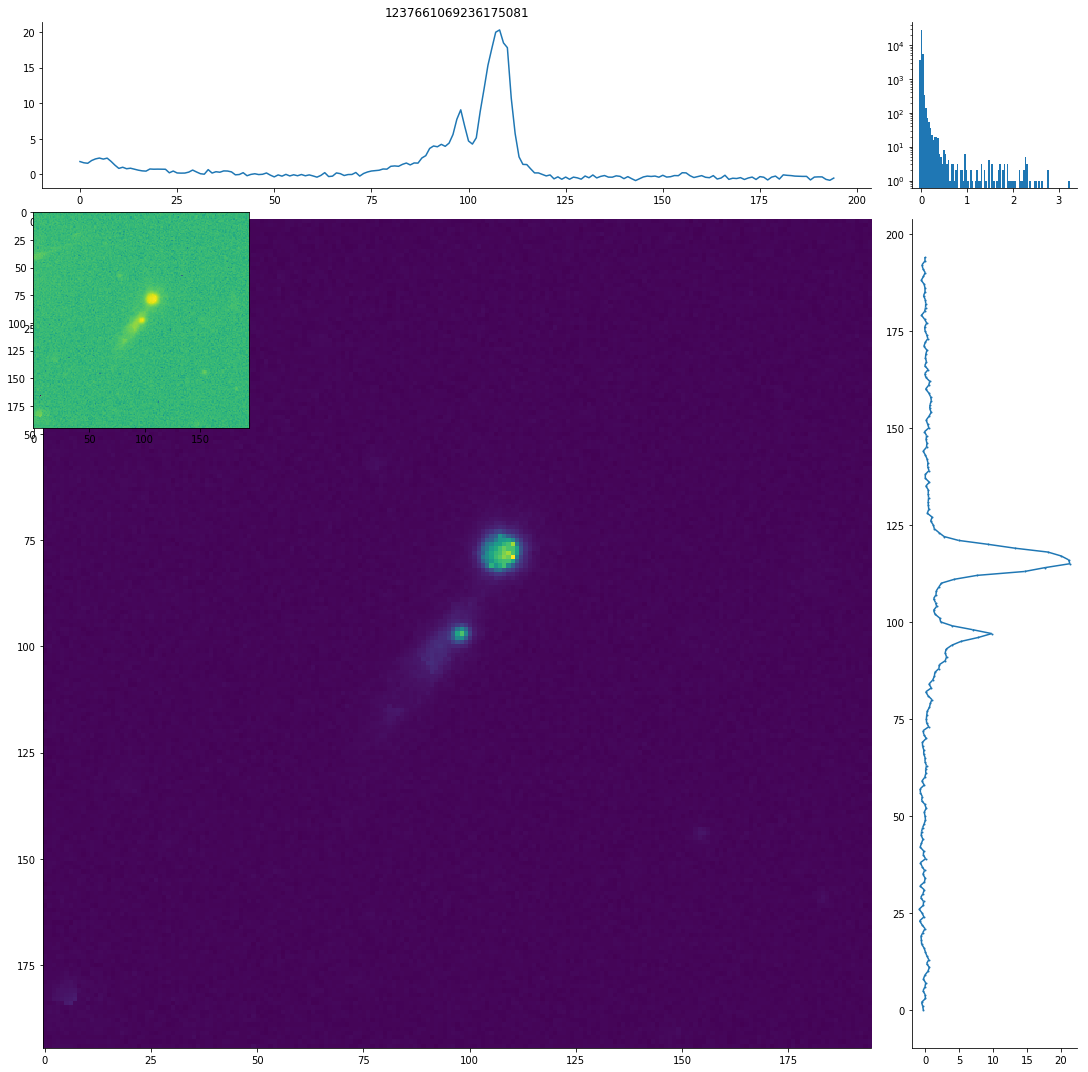

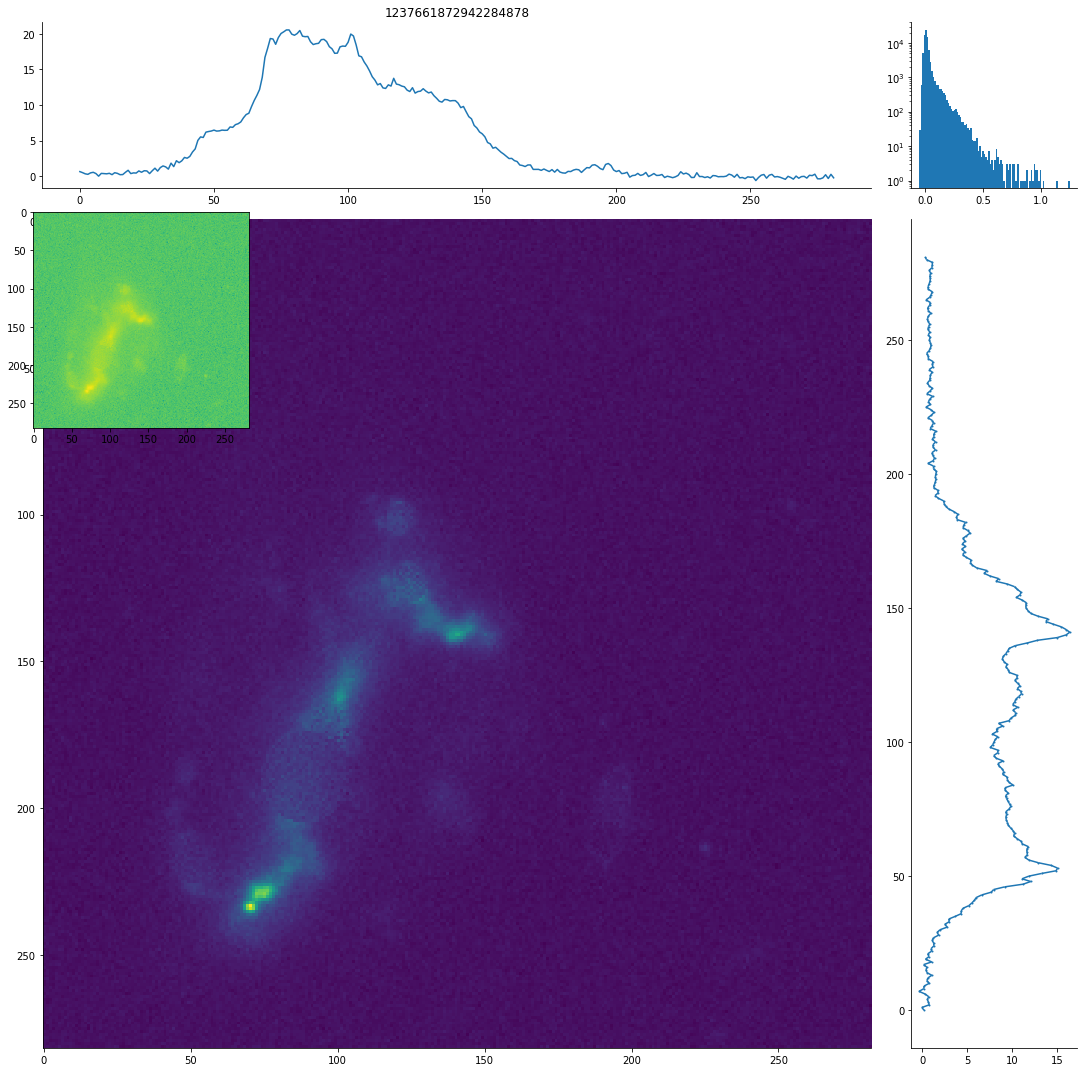

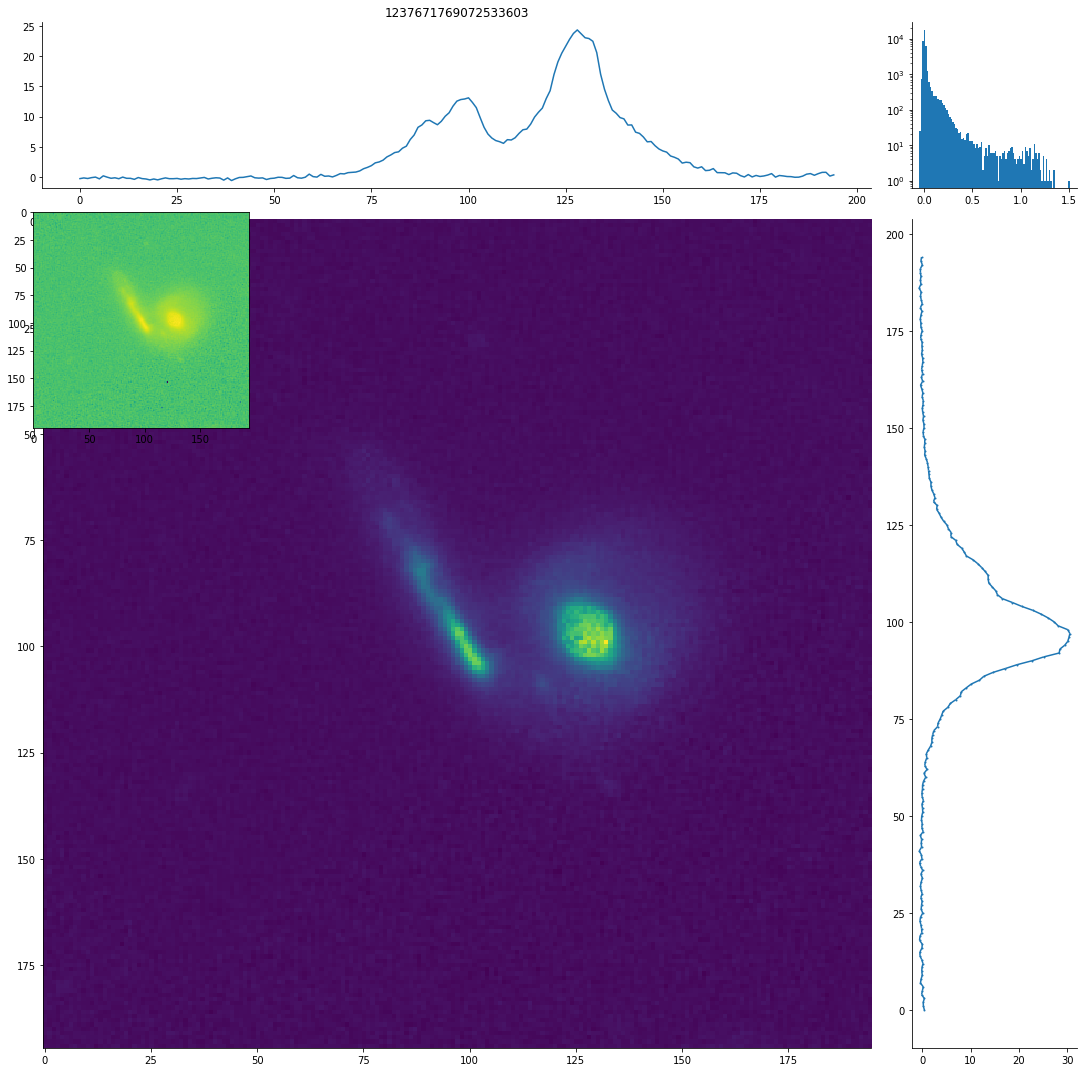

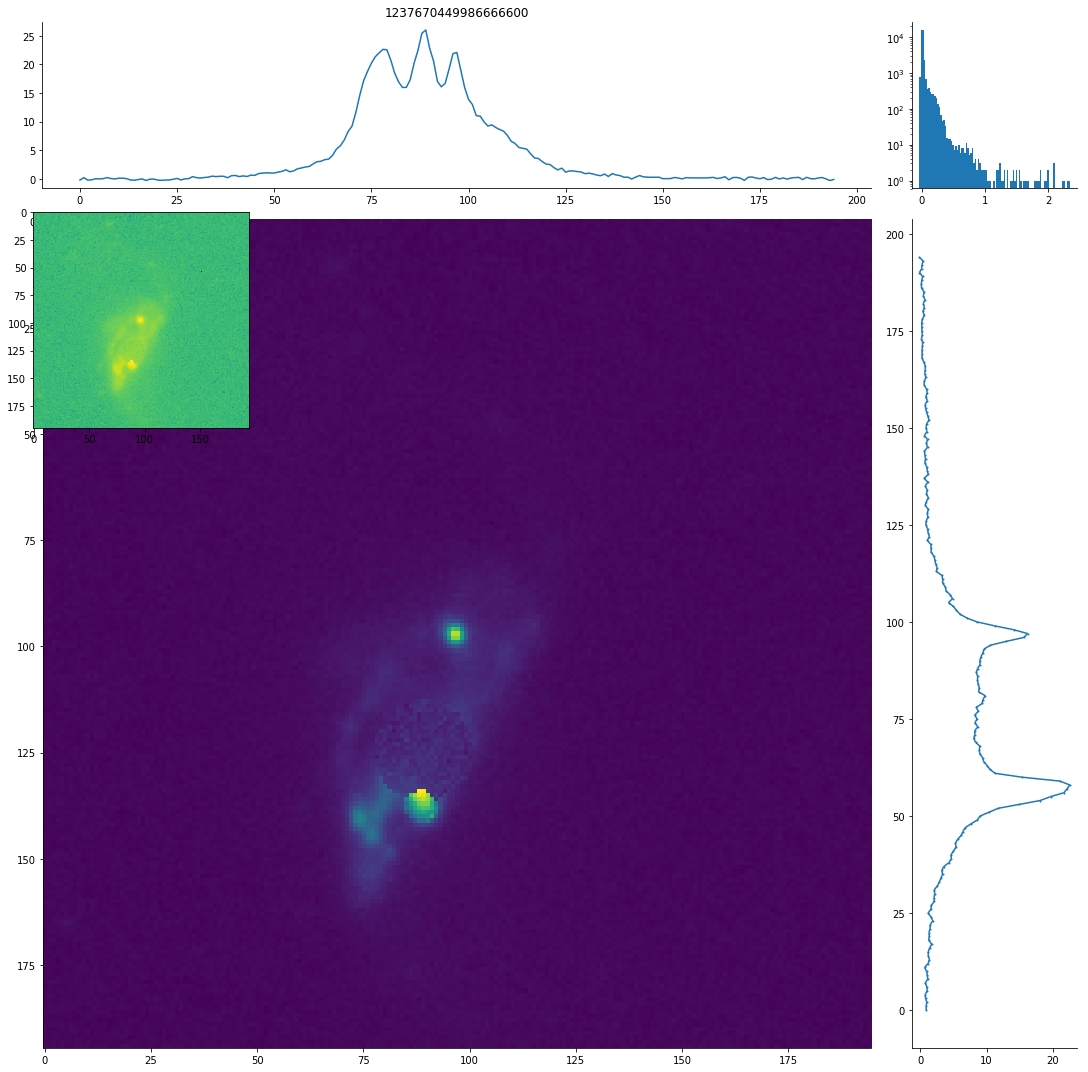

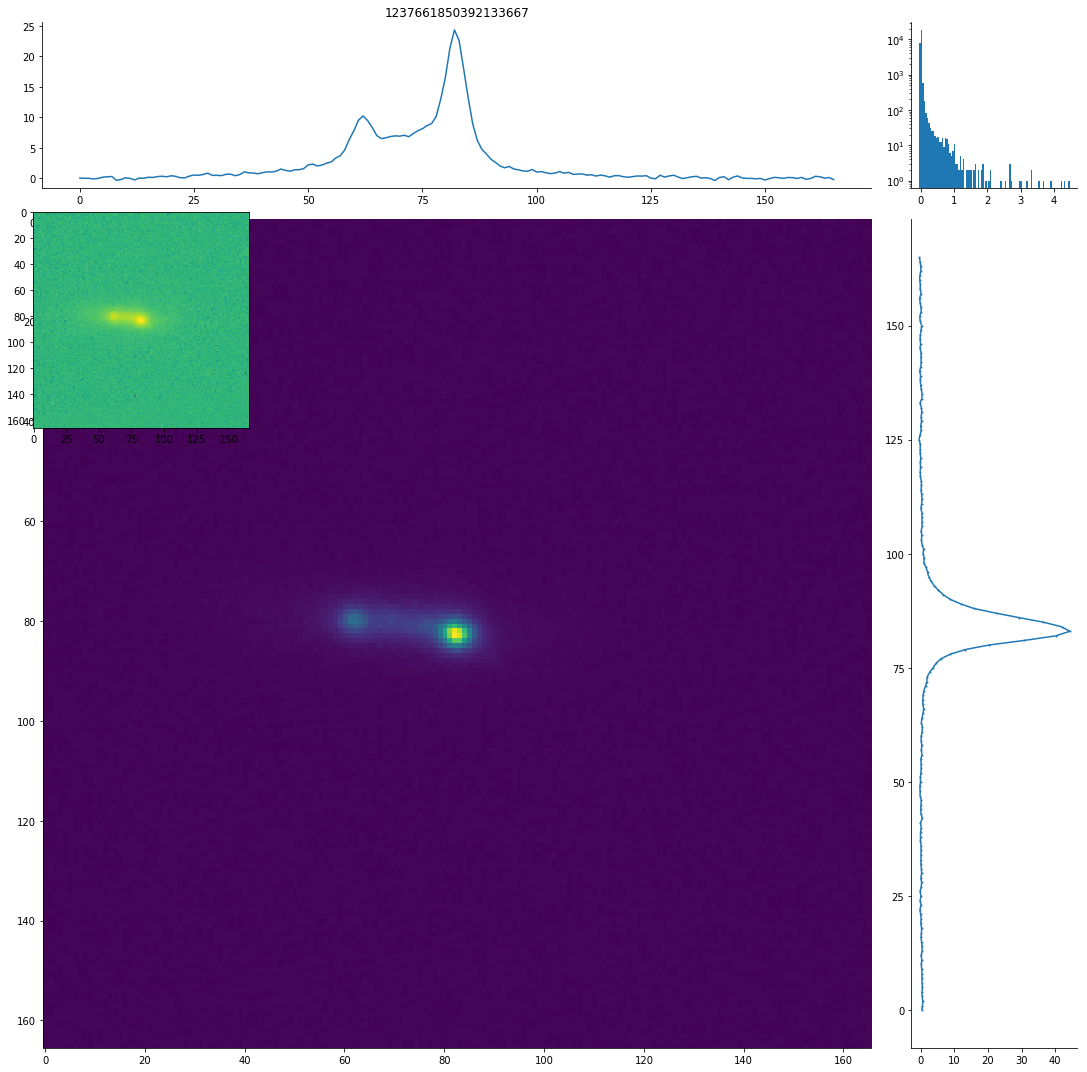

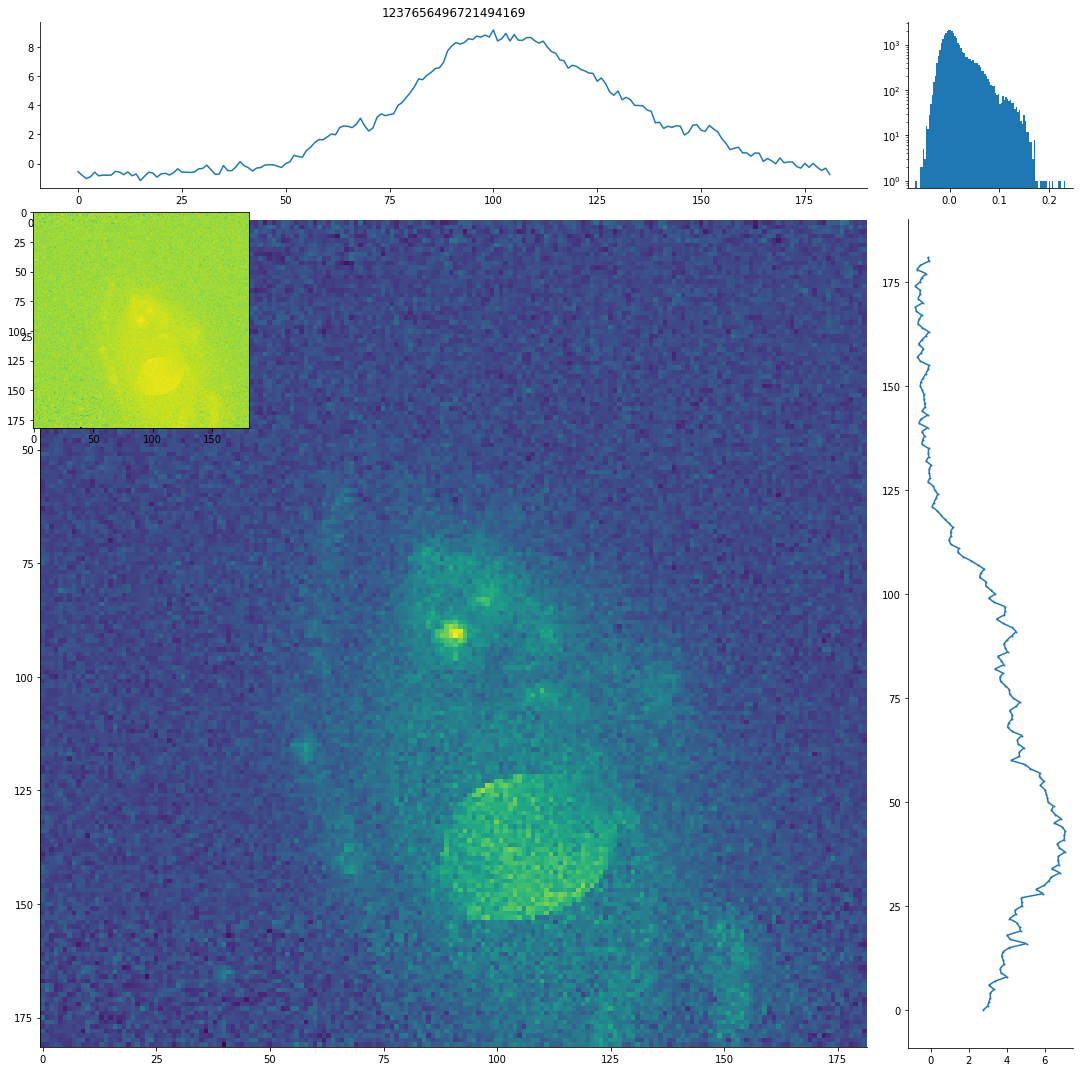

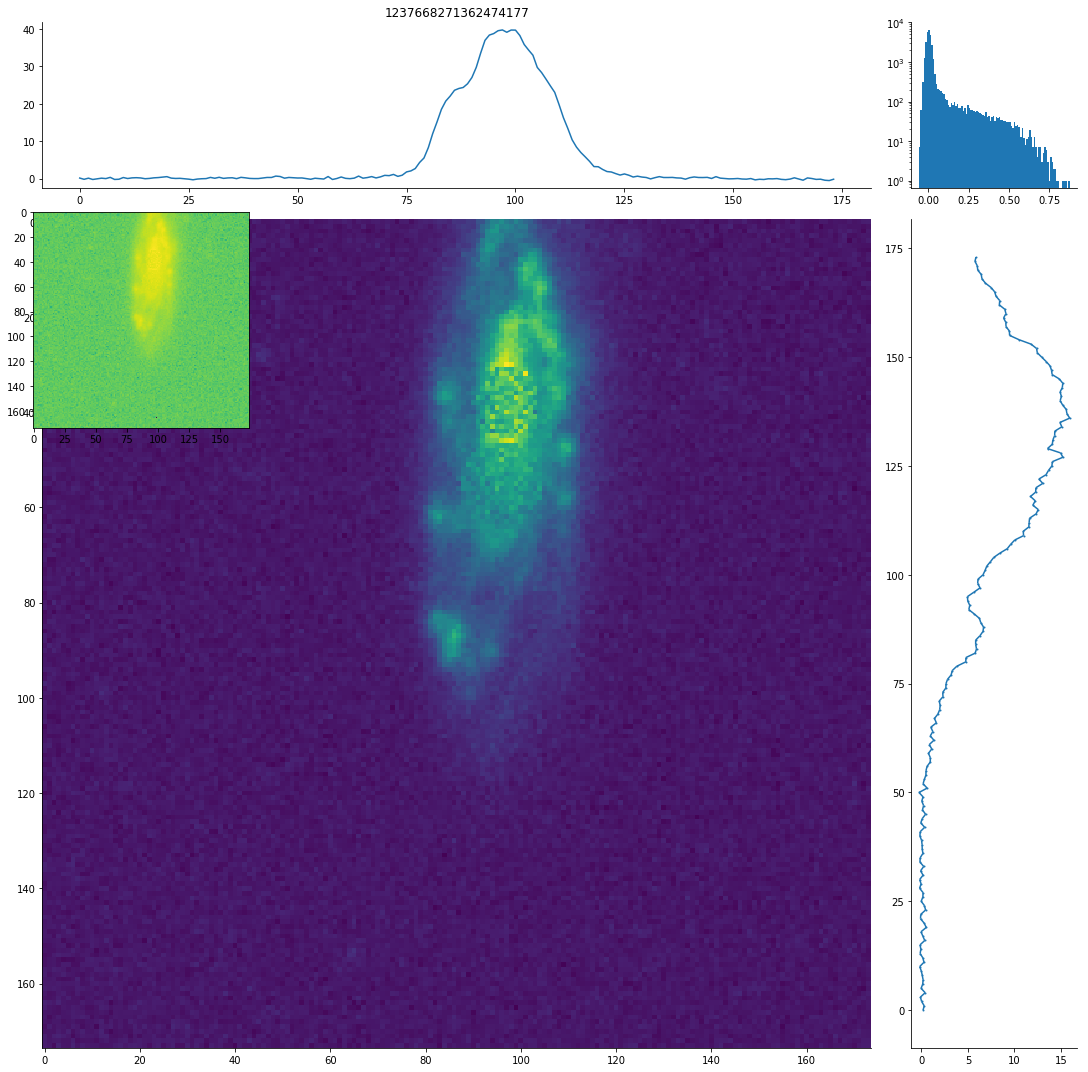

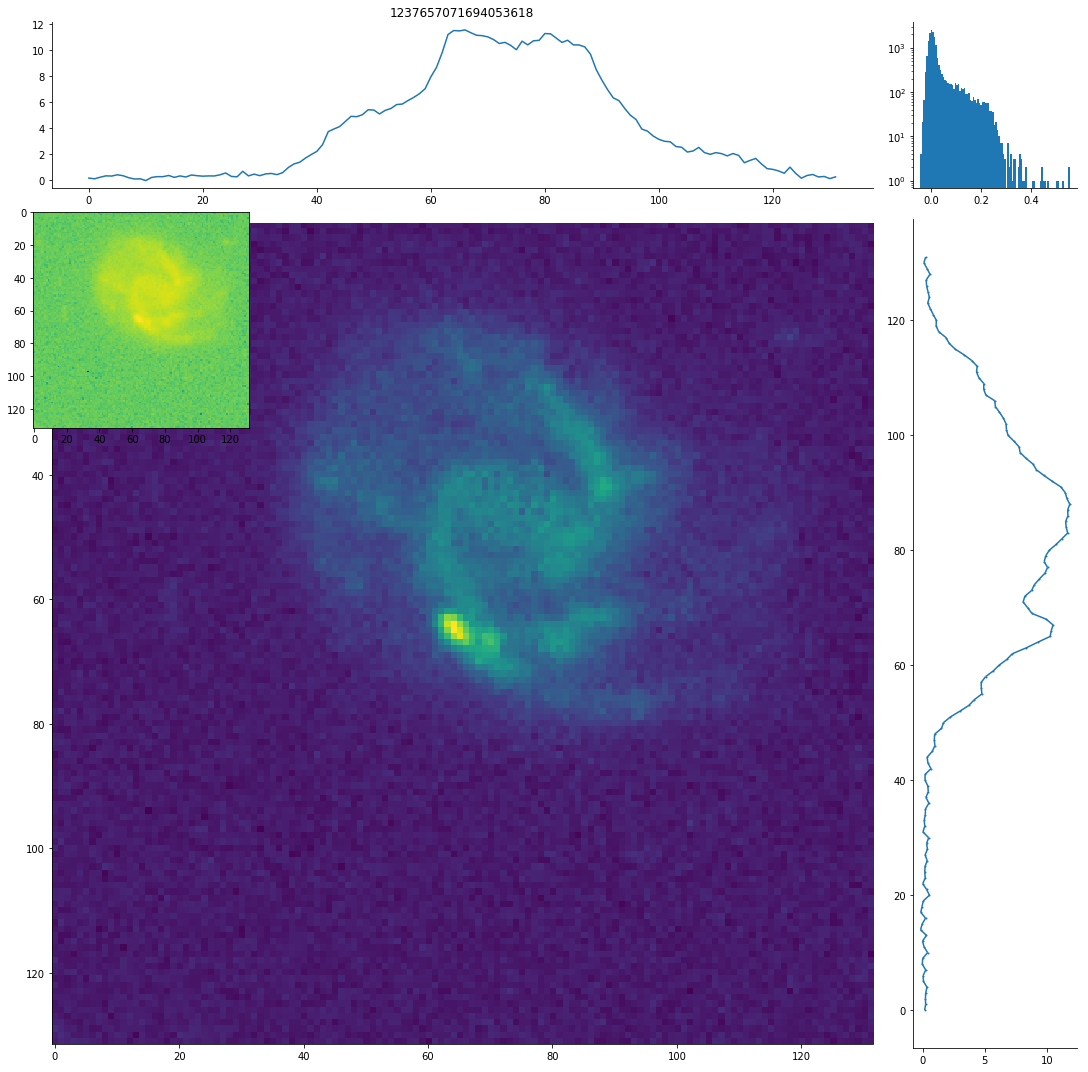

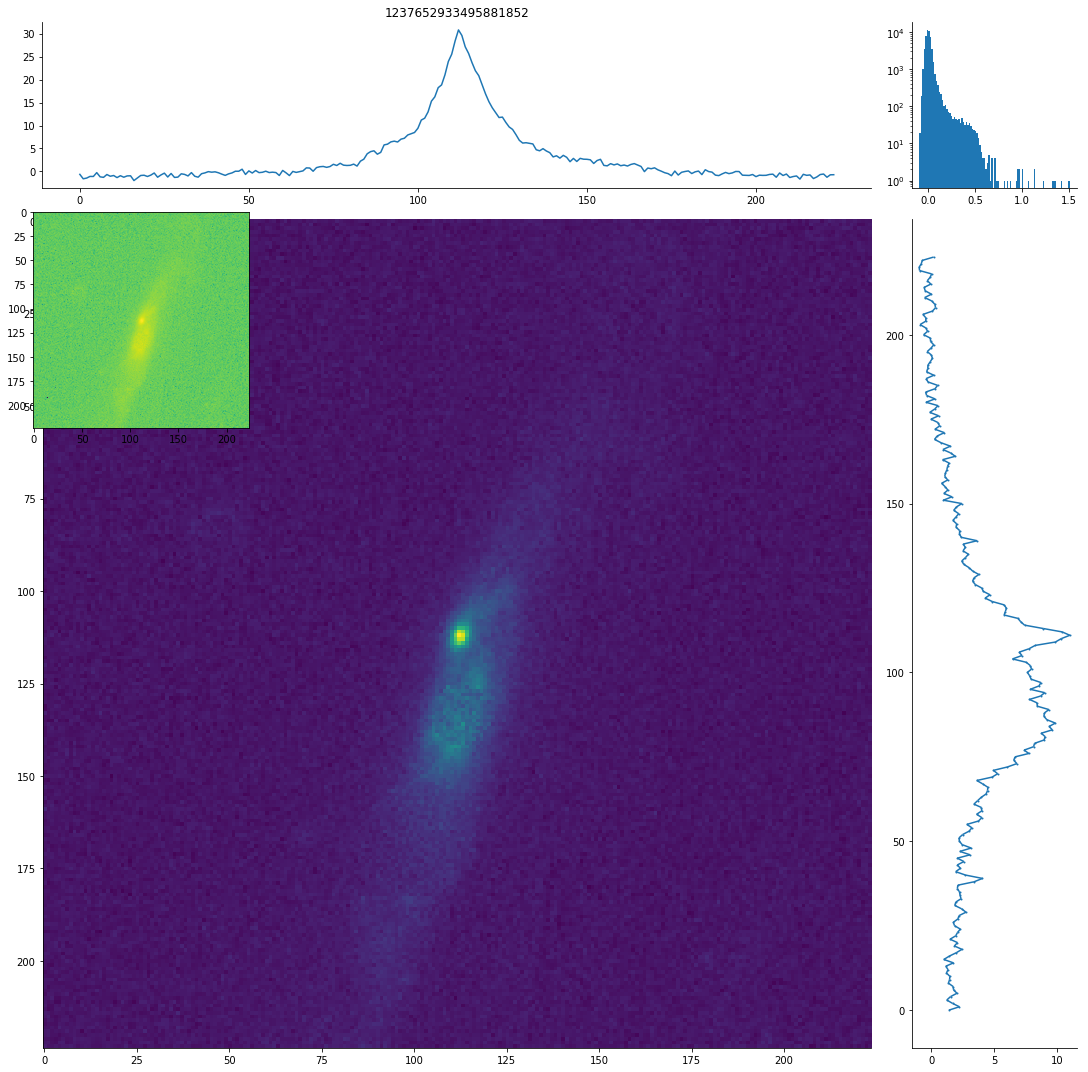

In [27]:
df.head()

for i in df['SDSS_ID'][:10]:
    drawOneGalaxy(str(i))